Several experiments were conducted to test different approaches for defining the sets of retailers and parameter settings. The conclusion is that grouping sets based on `per SIC per customer` performs best, with 20 hidden layer dimensions. The most important information used are `sectore (SIC)` and `individual shopping habits (customer)`. Shopping frequencies also play an important role. Due to limited time, we won't explore further on the embedding, several ideas might be used for further improvements:
 - combine `per SIC per customer` with `per SIC per day`
 - the shopping orders of transactions during a day (only if the data contains time info, which unfortunately not available)
 - group retailers based on average purchase amount
 - ratings and tags of the `eating places` from Yelp
 - geographic info

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import datetime
import random

In [2]:
df = pd.read_csv('data/cc_data.csv')
#df = df[-1000:]

d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[['Transaction ID','Consumer ID','Normalized Retailer','SIC Description','Purchase Amount','Transaction Date']]
df['Transaction Date'].replace({"N\A":None}, inplace=True)
df.dropna(inplace=True)
df.index = pd.to_datetime(df['Transaction Date']) # Use date as index
print("Total records used: %d" % df.shape[0])
df.head()

Total records used: 3606713


,Transaction ID,Consumer ID,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date
Transaction Date,,,,,,
2019-07-01,5d1d39c04c4557706c306356,9Ighlw/JUNpVLeFPSobJKg==\n,Red Robin,Eating Places,15.52,2019-07-01
2019-09-30,5d965b0d70604370c902eeb5,+t2ADZ35Xdau3nKCk+nQ8Q==\n,California Thai,Eating Places,11.29,2019-09-30
2019-06-24,5d31e8b4b2b9da7064c008e8,3Oc+K+HkYw+Eum7AJ72kmQ==\n,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24
2018-10-01,5bdbf2b498ae184ab49c1bbe,uaxLR/i0IiwOE6caF/XLpw==\n,The Beer Store,Liquor Stores,88.90,2018-10-01
2019-12-01,5de77889dbf7856e7efccc4b,0uZUEliqXSjPlB/UTgvjUQ==\n,Intermarche,Grocery Stores,23.54,2019-12-01


In [4]:
retailer_list = list(df['Normalized Retailer'].unique())
print(retailer_list[:20])
print("Numbers of retailers: %d" % len(retailer_list))

['Red Robin', 'California Thai', 'Petro-Canada', 'The Beer Store', 'Intermarche', "Harvey's", 'Pet Valu', 'Bc Liquor Stores', 'Amazon', 'Fas Gas', 'Esso', "Wendy's", 'Tim Hortons', 'H Mart', 'KFC', "Mac's Convenience Store", 'Subway', 'Metro', "McDonald's", 'Canadian Tire Store']
Numbers of retailers: 2449


In [5]:
SIC_list = list(df['SIC Description'].unique())
print(SIC_list[:10])
print("Numbers of Sectors: %d" % len(SIC_list))

['Eating Places', 'Gasoline Service Stations', 'Liquor Stores', 'Grocery Stores', 'Optical Goods Stores', 'Book Stores', 'Variety Stores', 'Hardware Stores', 'Communications Services, Not Elsewhere Classified', 'Taxicabs']
Numbers of Sectors: 114


In [6]:
## create dictionary from SIC to retailer
#retailer_map = defaultdict(list) # DO NOT USE dict.fromkeys, which appends retailer to every key
#
#for i in range(len(retailer_list)):
#    tmp_SIC = df.loc[df['Normalized Retailer'] == retailer_list[i]]['SIC Description'][0] 
#    retailer_map[tmp_SIC].append(retailer_list[i])

In [7]:
# view selected key-values from the dictionary
#dict(list(retailer_map.items())[7: 9])
#retailer_map['Liquor Stores']

In [8]:
# create retailer sets grouped by SIC
def groupBySIC(df):
    df_group = df.groupby('SIC Description').agg(lambda x: x.unique().tolist())
    training_data = df_group['Normalized Retailer'].tolist()
    training_data = [x for x in training_data if len(x) > 1] # remove sets containing only one retailer
    return training_data

In [9]:
# create reatiler sets grouped by SIC and day
def groupBySICAndDay(df):
    df_group = df.groupby(['SIC Description',pd.Grouper(freq = 'D')]).agg(lambda x: x.tolist())
    training_data = df_group['Normalized Retailer'].tolist()
    training_data = [x for x in training_data if len(x) > 1]
    return training_data

In [10]:
# create reatiler sets grouped by SIC and consumer
def groupBySICAndPerson(df):
    df_group = df.groupby(['SIC Description','Consumer ID']).agg(lambda x: x.tolist())
    training_data = df_group['Normalized Retailer'].tolist()
    training_data = [x for x in training_data if len(x) > 1]
    return training_data

In [11]:
# create retailer sets grouped by individual and shopping frequency
# 1, group by daily shopping > day_threshold
# 2, discard records used in step 1
# 3, group by weekly shopping > week_threshold
# 4, put two groups together

def groupByPersonAndTime(df,day_threshold = 2,week_threshold = 2):
    
    # create retailer sets grouped by customer and daily shopping
    df_groupbyday = df.groupby(['Consumer ID',pd.Grouper(freq = 'D')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyday = df_groupbyday['Normalized Retailer'].tolist()
    setbyday = [x for x in setbyday if len(x) >= day_threshold]    
    print("Records percentage used from daily group: %.2f" % (sum([len(listElem) for listElem in setbyday])/df.shape[0]*100))
    
    # Transaction ID records not used yet
    tmp = df_groupbyday['Transaction ID'].tolist()
    tmp = [x for x in tmp if len(x) < day_threshold] 
    IDs2keep = [item for sublist in tmp for item in sublist]
    
    # df without records used in previous step
    df_removedays = df[df['Transaction ID'].isin(IDs2keep)]
    
    # create retailer sets grouped by customer and weekly shopping
    df_groupbyweek = df_removedays.groupby(['Consumer ID',pd.Grouper(freq = 'W')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyweek = df_groupbyweek['Normalized Retailer'].tolist()
    setbyweek = [x for x in setbyweek if len(x) >= week_threshold] 
    print("Records percentage used from weekly group: %.2f" % (sum([len(listElem) for listElem in setbyweek])/df.shape[0]*100))
    
    return setbyday + setbyweek

In [12]:
start = datetime.datetime.now()

#training_data = groupByPersonAndTime(df,day_threshold = 5, week_threshold = 5)
#training_data = groupBySIC(df)
#training_data = groupBySICAndDay(df)
training_data = groupBySICAndPerson(df)

print("Sets creating time: " + str(datetime.datetime.now()-start))

Sets creating time: 0:05:32.740380


In [13]:
training_data[:7]

[['CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv', 'CraveTv', 'CraveTv'],
 ['CraveTv', 'CraveTv', 'CraveTv']]

In [14]:
start = datetime.datetime.now()

model = Word2Vec(sentences = training_data, # list of sets of retailers
                 iter = 10, # epoch
                 min_count = 5, # a retailer has to appear more than min_count times to be kept
                 size = 20, # hidden layer dimensions
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 10, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Model training time: " + str(datetime.datetime.now()-start))

Model training time: 0:01:43.448070


In [28]:
# save the model
#model.save("models/perSICperPerson.model")

In [16]:
# check dictionary
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

CraveTv
Linkedin
Hoot Suite
Marineland Canada
Sea World
Canada's Wonderland
Legoland
Toronto Zoo
Wet N Wild
Disneyland


In [17]:
# check vector given a certain word from the dictionary
print(model.wv['Amazon'])

[ 0.9447276  -0.9806521  -0.06156445 -0.8949955   1.2392675   2.6789424
 -0.42560124 -0.2243028  -2.8534315   1.3425173  -0.03968062  1.1653463
  1.4528311  -1.8303243  -0.18277217  1.012474    2.3869252   1.580352
 -2.5791364   1.0444418 ]


In [18]:
# calculate similarity between two words
pairs = [
    ("Netflix", "Rogers"), 
    ("Netflix", "Starbucks"),   
    ("Tim Hortons", "Starbucks"), 
    ("Tim Hortons", "McDonald's")
]
print("Similarity comparison\n")
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

Similarity comparison

'Netflix'	'Rogers'	0.92
'Netflix'	'Starbucks'	0.33
'Tim Hortons'	'Starbucks'	0.21
'Tim Hortons'	"McDonald's"	0.86


In [19]:
# find out most similar terms
print(model.wv.most_similar(positive=['Amazon'], topn=3))

[('Mc Graw Hill', 0.9724454283714294), ('Apple', 0.9681169986724854), ('Dell Canada Inc', 0.9669002294540405)]


In [20]:
# visualize all words
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
        
def plot_with_seaborn(df):
    random.seed(0)
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data = df, x="x_vals", y="y_vals", hue="SIC", s=70, legend = 'brief');

    # put legend outside the box
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # randomly label the retailers
    indices = list(range(df.shape[0]))
    selected_indices = random.sample(indices, 20)
    for i in selected_indices:
        plt.annotate(df.labels[i], (df.x_vals[i], df.y_vals[i]))

In [21]:
# obtain two dimension coordinates for retailers
x_vals, y_vals, labels = reduce_dimensions(model)

In [22]:
# create SIC list for corresponded retailer
labels_SIC = []
for i in range(len(labels)):
    tmp_SIC = df.loc[df['Normalized Retailer'] == labels[i]]['SIC Description'][0] 
    labels_SIC.append(tmp_SIC)

In [23]:
# put x_vals, y_vals, labels, labels_SIC into one dataframe
tmp_list = list(zip(x_vals,y_vals,labels,labels_SIC))
df2plot = pd.DataFrame(tmp_list, columns=['x_vals','y_vals','labels','SIC'])
print("Number of retailers for visualization: %d" % len(labels))
df2plot.head()

Number of retailers for visualization: 1911


,x_vals,y_vals,labels,SIC
0,-0.939237,-3.819420,CraveTv,Advertising Agencies
1,-1.632556,-2.907451,Linkedin,Advertising Agencies
2,-30.982534,-2.132832,Hoot Suite,Advertising Agencies
3,-2.841220,3.924678,Marineland Canada,Amusement Parks
4,-4.084902,6.113233,Sea World,Amusement Parks


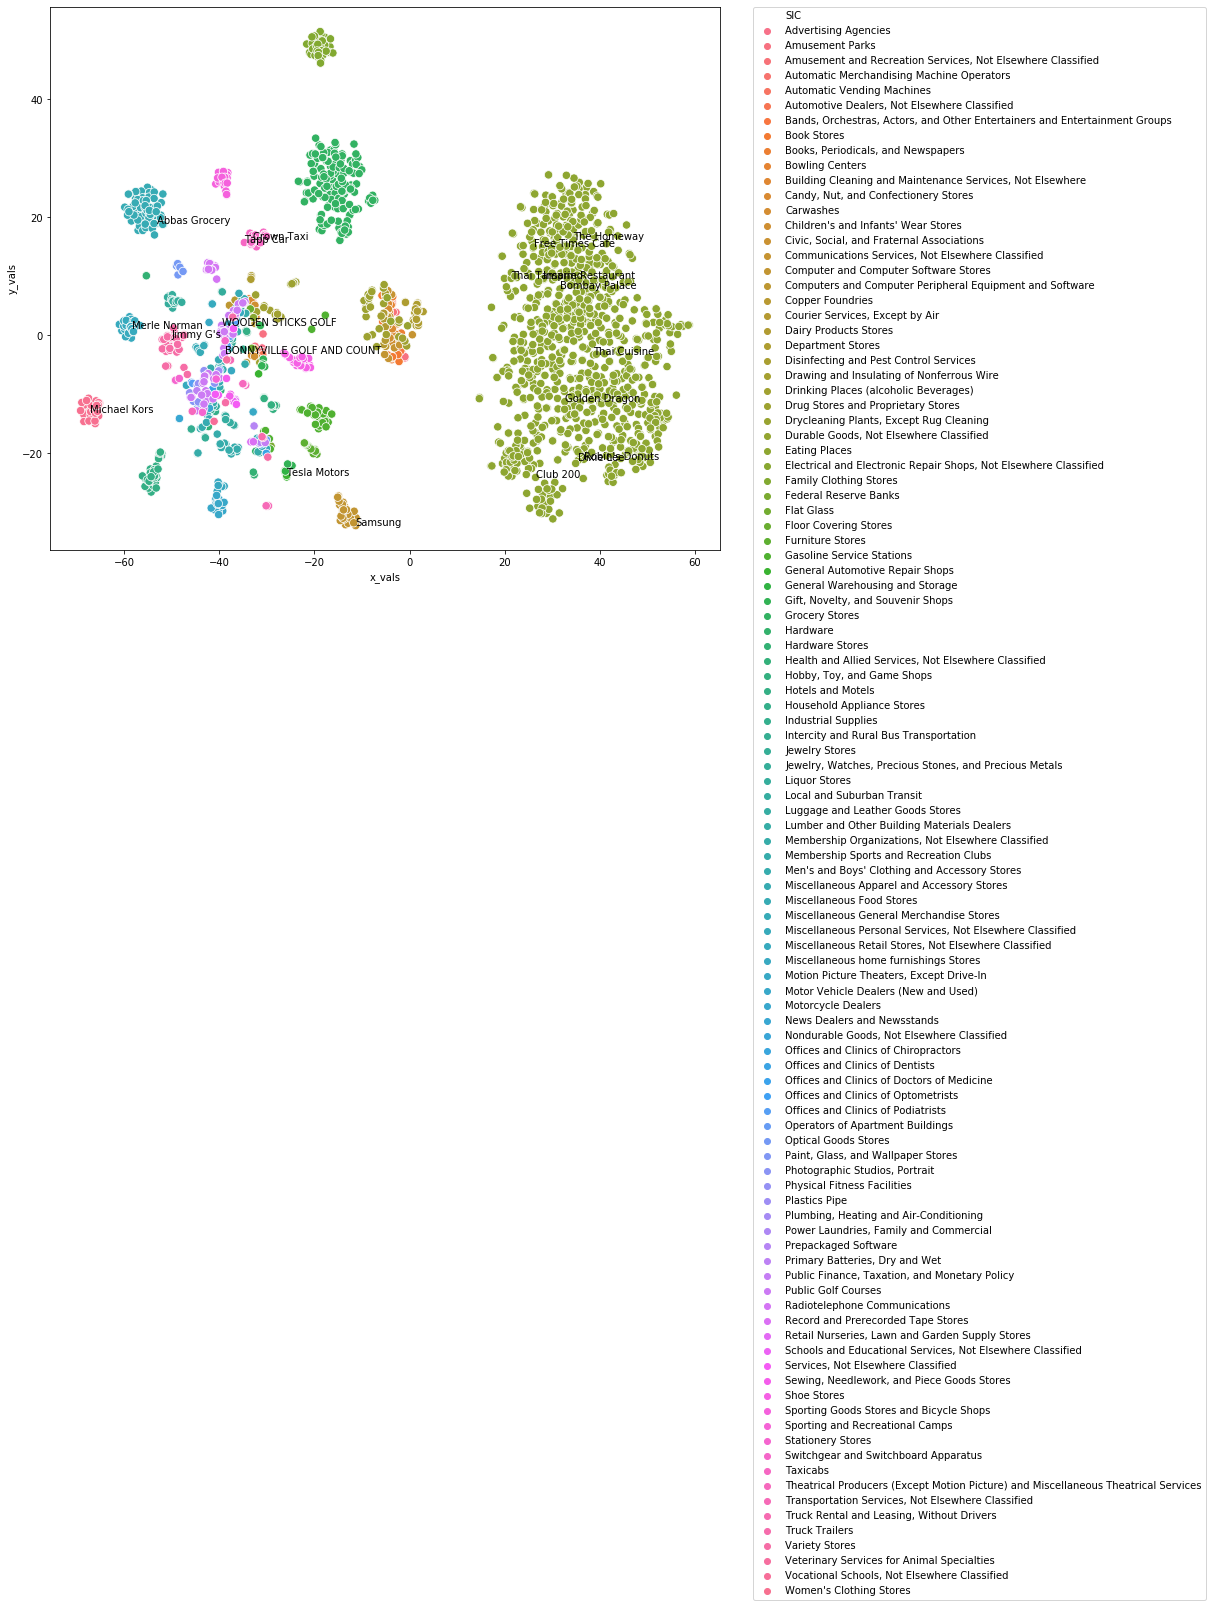

In [24]:
plot_with_seaborn(df2plot)

In [38]:
def selectTopSIC(df, N = 5):
    df_pivot = df.groupby(by = 'SIC Description', as_index=False).agg({'Transaction ID': pd.Series.nunique})
    df_pivot.columns = ['SIC Description', 'Counts']
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    list2plot = list(df_pivot.nlargest(N, 'Counts')['SIC Description'])
    return list2plot

In [40]:
# only plot top N sectors
N = 10
list2plot = selectTopSIC(df, N)
print(list2plot)
df2plot_topN = df2plot[df2plot['SIC'].isin(list2plot)]
df2plot_topN.reset_index(inplace = True)
df2plot_topN.head()

['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Drug Stores and Proprietary Stores', 'Family Clothing Stores', 'Miscellaneous Food Stores', 'Taxicabs', 'Department Stores', 'Communications Services, Not Elsewhere Classified']


,index,x_vals,y_vals,labels,SIC
0,24,-4.574778,-3.309354,Amazon,Book Stores
1,25,-3.721100,-4.122658,Indigo,Book Stores
2,26,-3.607986,-3.814584,Chapters,Book Stores
3,27,-3.533667,-3.729185,Coles,Book Stores
4,28,-2.199933,-4.433019,Kobo,Book Stores


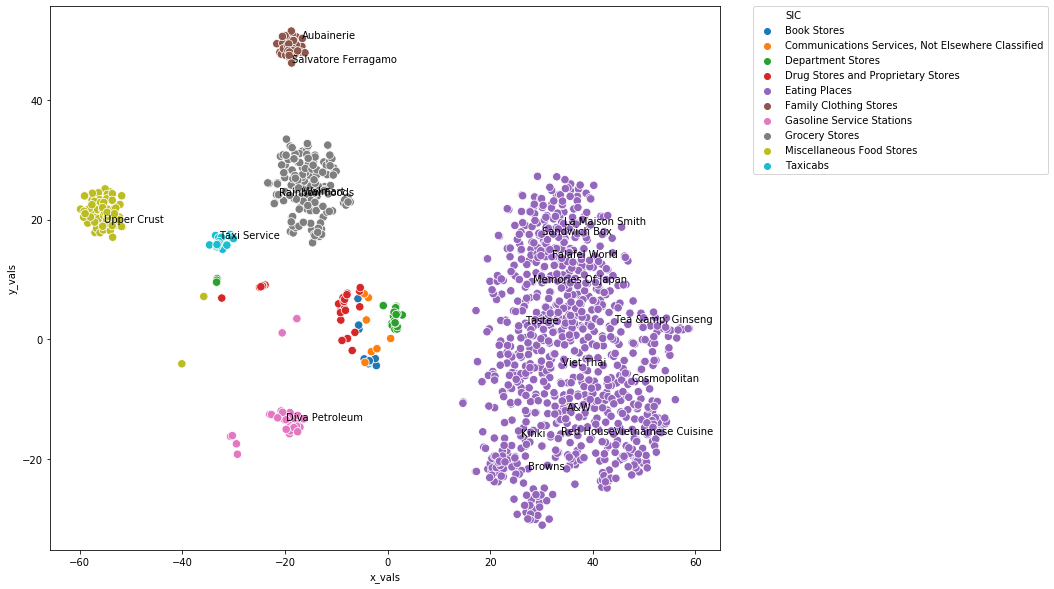

In [41]:
plot_with_seaborn(df2plot_topN);
plt.savefig('figs/exp_07.png',bbox_inches='tight')

In [27]:
#plot_with_matplotlib(x_vals, y_vals, labels)